<a href="https://colab.research.google.com/github/tejasreejilla/codealpha_tasks/blob/main/basic_network_sniffer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install scapy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 22.2 MB/s eta 0:00:00


In [ ]:
pip install geoip2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.7/87.7 kB 3.8 MB/s eta 0:00:00


importing libraries

In [ ]:
import scapy.all as scapy
import matplotlib.pyplot as plt
from collections import defaultdict
import time
import threading
import socket
import geoip2.database
import json
import os
import datetime

global variables

In [ ]:
# Global variables
packet_count = 0
packet_data = defaultdict(int)  # Packet type statistics
traffic_data = []  # List to store traffic data (bytes per second)
packet_timestamps = []  # Timestamps for calculating time intervals

packet analysis functions

In [ ]:
# DOS attack detection (SYN flooding detection)
syn_count = defaultdict(int)

def packet_callback(packet):
    global packet_count, syn_count, packet_data, traffic_data, packet_timestamps

    packet_count += 1

    # Capture packet timestamps for latency calculation
    timestamp = datetime.datetime.now()
    packet_timestamps.append(timestamp)

    # Track packet types (IP, TCP, UDP, ICMP)
    if packet.haslayer(scapy.IP):
        ip_src = packet[scapy.IP].src
        ip_dst = packet[scapy.IP].dst
        packet_data['IP'] += 1

        if packet.haslayer(scapy.TCP):
            packet_data['TCP'] += 1
            if packet[scapy.TCP].flags == "S":  # Detect SYN packets (for SYN flood)
                syn_count[ip_src] += 1
                if syn_count[ip_src] > 100:  # Threshold for SYN flood detection
                    print(f"Possible SYN Flood Detected from {ip_src}")

        elif packet.haslayer(scapy.UDP):
            packet_data['UDP'] += 1
        elif packet.haslayer(scapy.ICMP):
            packet_data['ICMP'] += 1

        # Capture DNS queries/responses
        if packet.haslayer(scapy.DNS):
            if packet[scapy.DNS].qr == 0:
                print(f"DNS Query: {packet[scapy.DNS].qd.qname}")
            elif packet[scapy.DNS].qr == 1:
                print(f"DNS Response: {packet[scapy.DNS].an.rdata}")

        # Capture HTTP requests
        if packet.haslayer(scapy.TCP) and packet[scapy.TCP].dport == 80:
            if packet.haslayer(scapy.Raw):
                raw_data = packet[scapy.Raw].load.decode(errors='ignore')
                if "HTTP" in raw_data:
                    print(f"HTTP Request Detected: {ip_src} -> {ip_dst}")

    # Capture the traffic rate (bytes per second)
    if len(packet_timestamps) > 1:
        time_diff = (timestamp - packet_timestamps[0]).total_seconds()
        if time_diff > 0:
            bytes_received = len(packet)
            traffic_data.append((time_diff, bytes_received))

    if packet_count % 100 == 0:
        plot_packet_data()

traffic rate calculation

Possible SYN Flood Detected from 172.28.0.1Possible SYN Flood Detected from 172.28.0.1
Possible SYN Flood Detected from 172.28.0.1



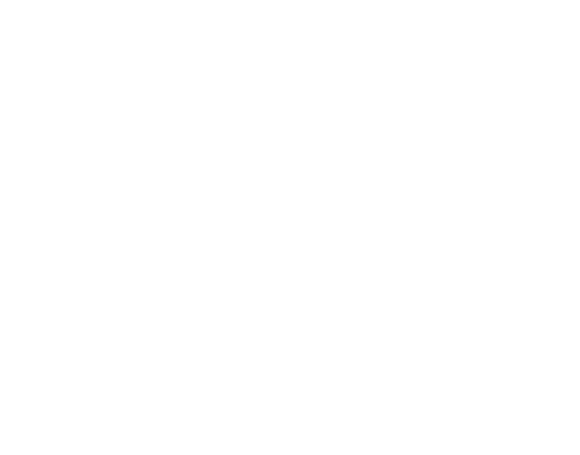

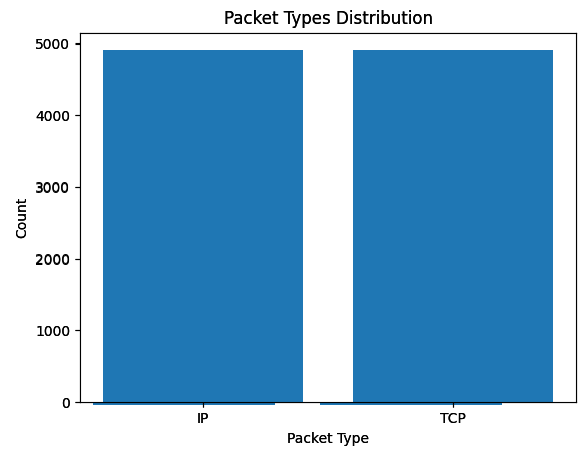

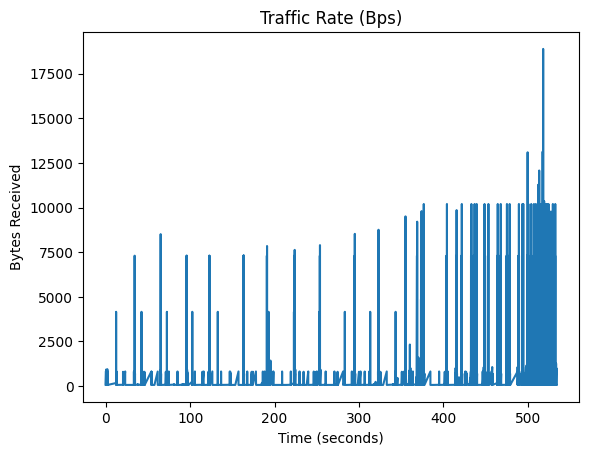

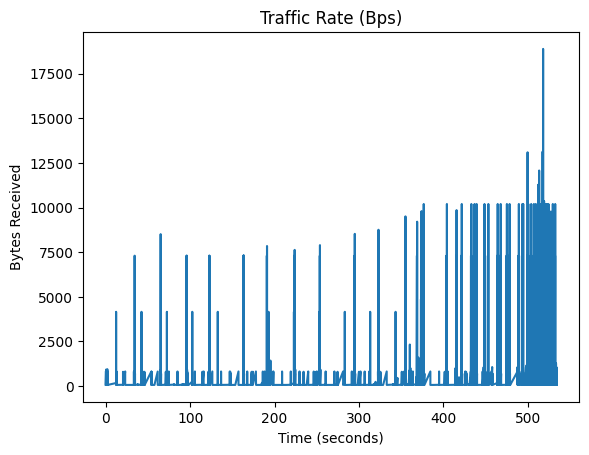

In [ ]:
def plot_packet_data():
    # Plot packet statistics
    types = list(packet_data.keys())
    counts = list(packet_data.values())

    plt.bar(types, counts)
    plt.title('Packet Types Distribution')
    plt.xlabel('Packet Type')
    plt.ylabel('Count')
    plt.show()

    # Plot traffic rate (bytes per second)
    if len(traffic_data) > 1:
        times = [data[0] for data in traffic_data]
        bytes_received = [data[1] for data in traffic_data]
        plt.plot(times, bytes_received)
        plt.title('Traffic Rate (Bps)')
        plt.xlabel('Time (seconds)')
        plt.ylabel('Bytes Received')
        plt.show()
plot_packet_data()

geo location of ip address

In [ ]:
# Geo-location lookup function
def get_geolocation(ip):
    try:
        reader = geoip2.database.Reader('GeoLite2-City.mmdb')  # Need the database file
        response = reader.city(ip)
        country = response.country.name
        city = response.city.name
        print(f"IP {ip} is located in {city}, {country}")
        reader.close()
    except Exception as e:
        print(f"Geo-location lookup failed for IP: {ip}")

attack detection and filtering enhancements

port scanning detection

In [ ]:
# Port scan detection: Track source IPs and ports
port_scans = defaultdict(set)

def detect_port_scan(packet):
    if packet.haslayer(scapy.IP) and packet.haslayer(scapy.TCP):
        src_ip = packet[scapy.IP].src
        src_port = packet[scapy.TCP].sport
        if src_port not in port_scans[src_ip]:
            port_scans[src_ip].add(src_port)
            if len(port_scans[src_ip]) > 10:  # Detect scan if more than 10 unique ports are used
                print(f"Possible Port Scan detected from {src_ip}")

packet saving and logging

In [ ]:
# Save packets to a file
def save_packets(packet):
    scapy.wrpcap("captured_packets.pcap", packet, append=True)

# Log packet details to a text file
def log_packet_details(packet):
    with open("packet_log.txt", "a") as log_file:
        log_file.write(f"{str(datetime.datetime.now())}: {str(packet)}\n")

threading of concurrent sniffing analysis and logging

In [ ]:
# Threading to run sniffing and other tasks concurrently
# Function to start sniffing (captures network packets)
def start_sniffing():
    print("Starting network sniffing...")
    scapy.sniff(prn=packet_callback, store=False)

def display_packet_statistics():
    global packet_data
    while True:
        time.sleep(10)  # Update stats every 10 seconds
        print(f"Packet Statistics: {dict(packet_data)}")

# Detect port scans (Detects multiple ports accessed from a single IP)
def detect_port_scan(packet):
    if packet.haslayer(scapy.IP) and packet.haslayer(scapy.TCP):
        src_ip = packet[scapy.IP].src
        src_port = packet[scapy.TCP].sport
        if src_port not in port_scans[src_ip]:
            port_scans[src_ip].add(src_port)
            if len(port_scans[src_ip]) > 10:  # Detect scan if more than 10 unique ports are used
                print(f"Possible Port Scan detected from {src_ip}")

# Threading to run sniffing and other tasks concurrently
def start_sniffing_thread():
    sniffing_thread = threading.Thread(target=start_sniffing)
    sniffing_thread.start()

def start_analysis_thread():
    analysis_thread = threading.Thread(target=display_packet_statistics)
    analysis_thread.start()

def start_attack_detection_thread():
    detection_thread = threading.Thread(target=detect_port_scan)
    detection_thread.start()

if __name__ == "__main__":
    start_sniffing_thread()
    start_analysis_thread()
    start_attack_detection_thread()

Starting network sniffing...


Exception in thread Thread-14 (detect_port_scan):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
TypeError: detect_port_scan() missing 1 required positional argument: 'packet'


running the sniffer

Sniffing on interface: eth0


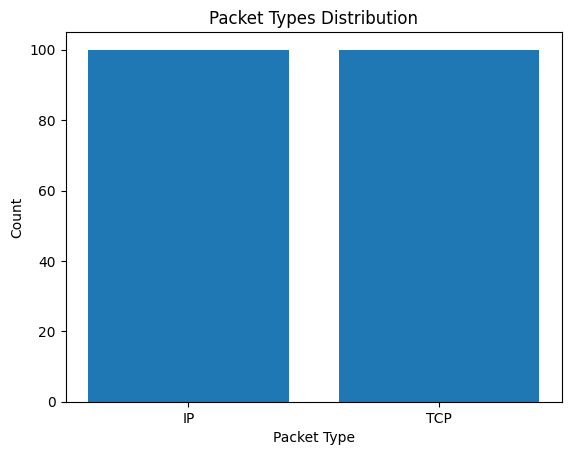

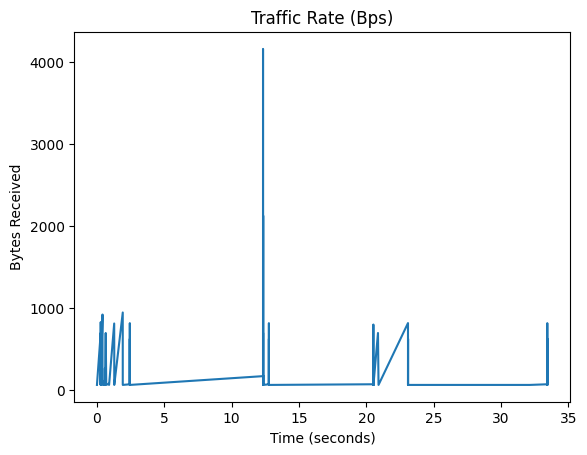

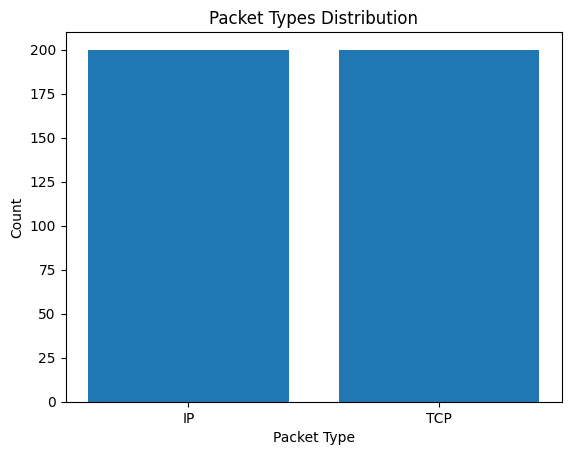

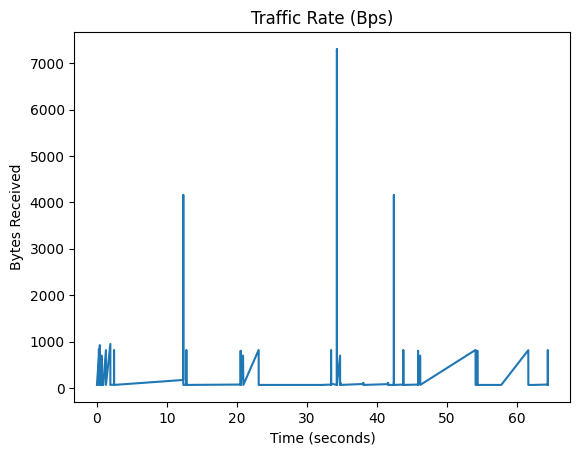

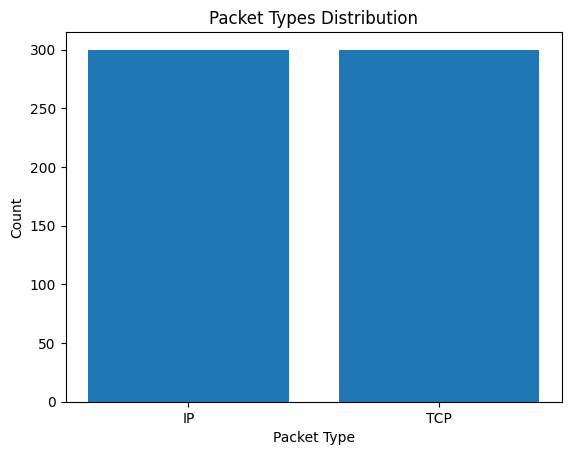

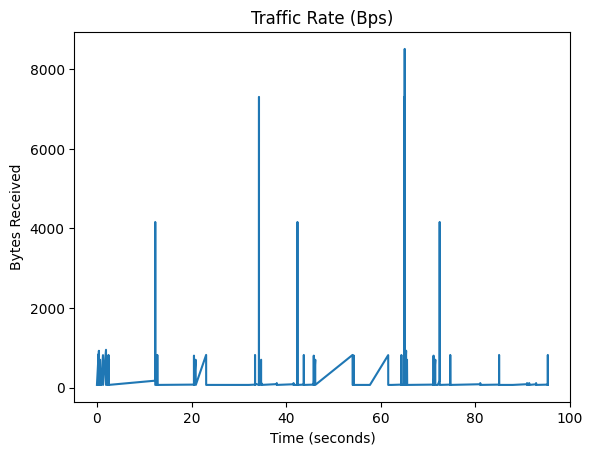

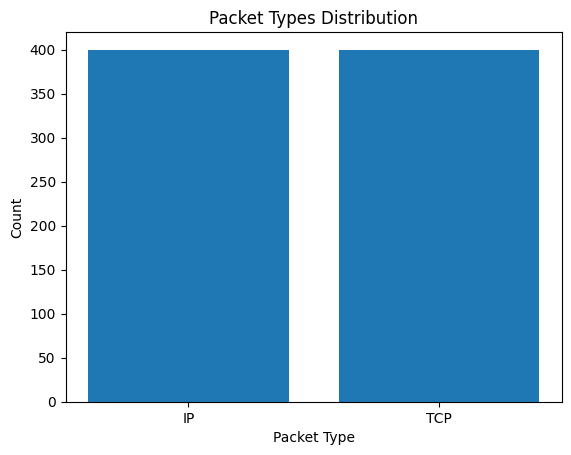

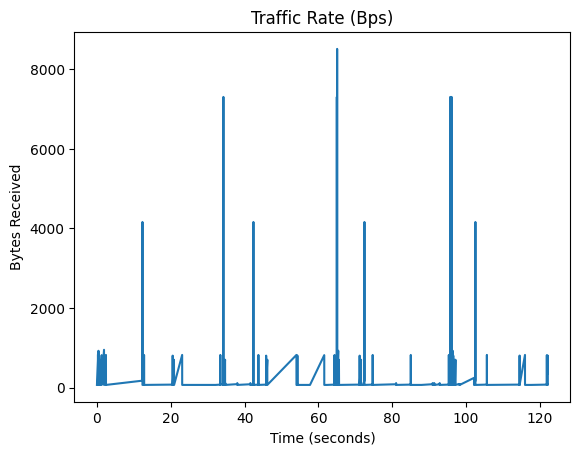

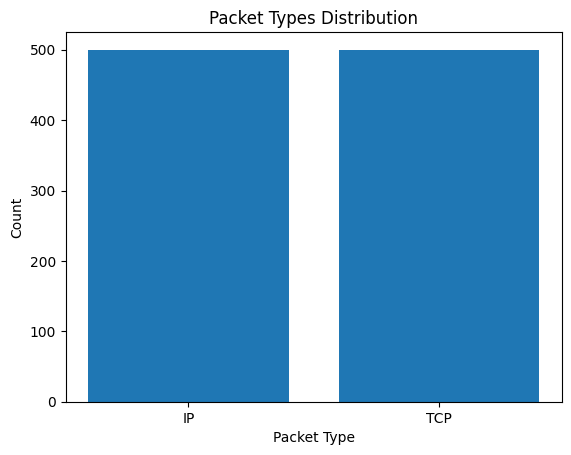

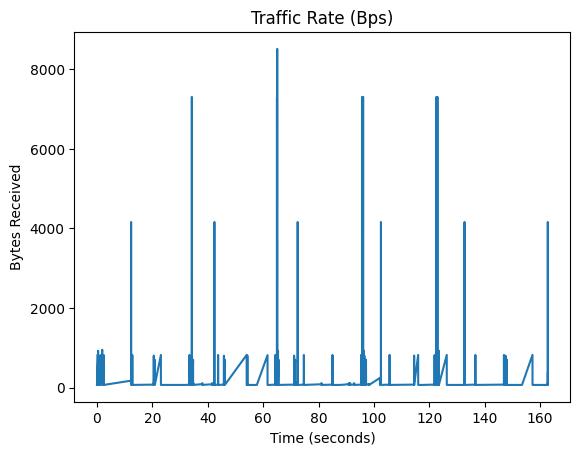

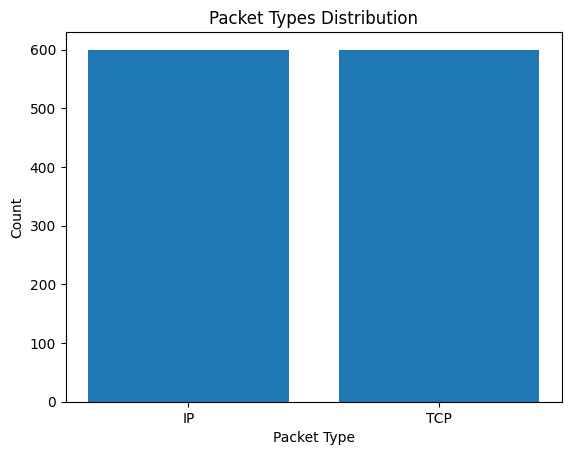

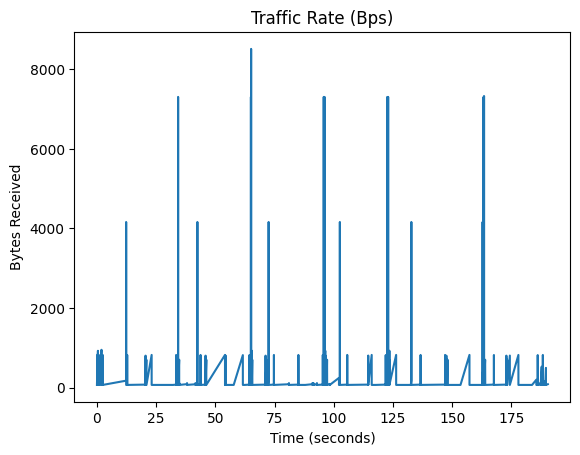

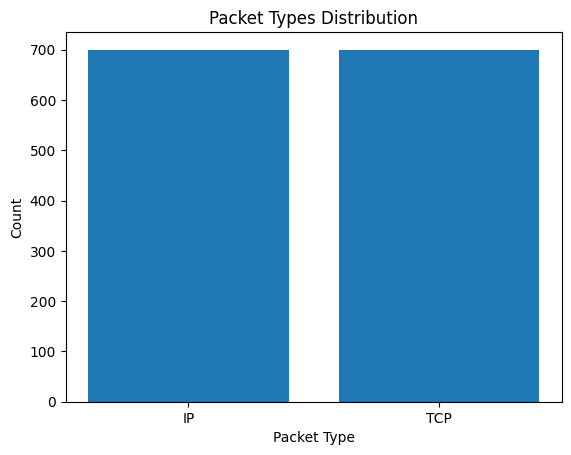

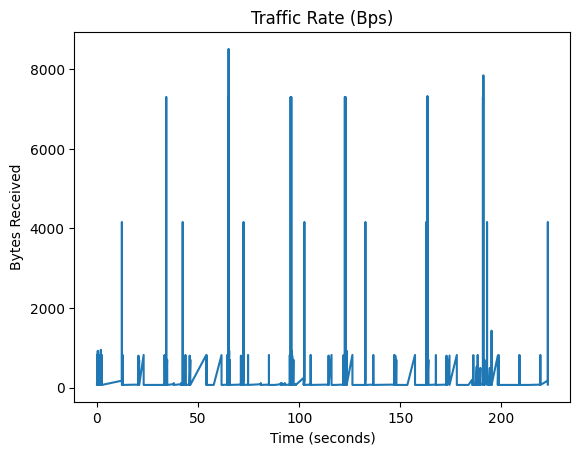

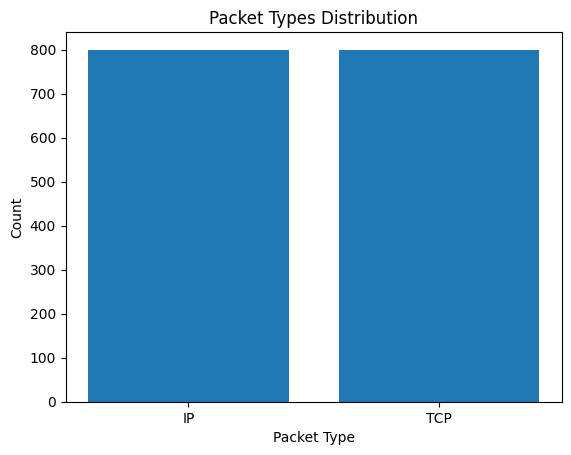

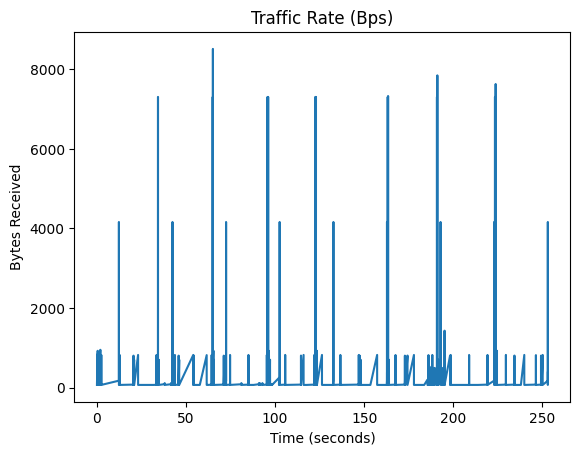

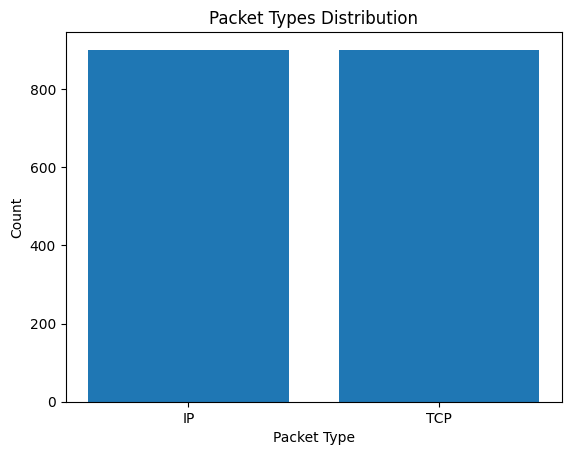

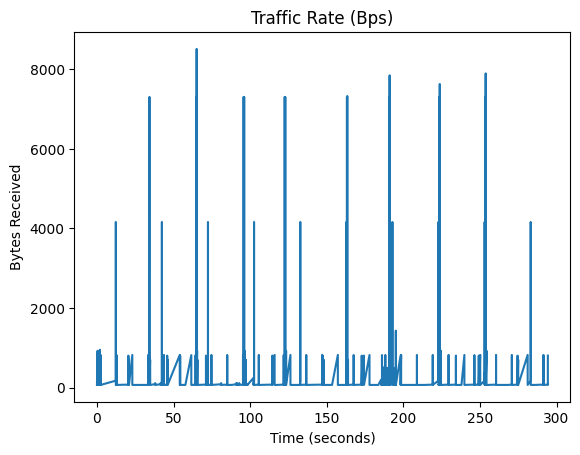

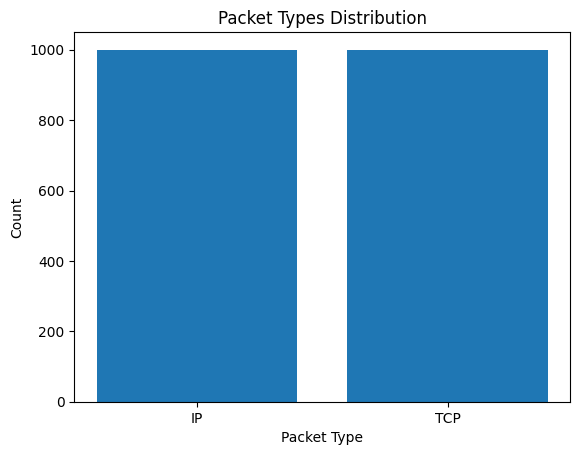

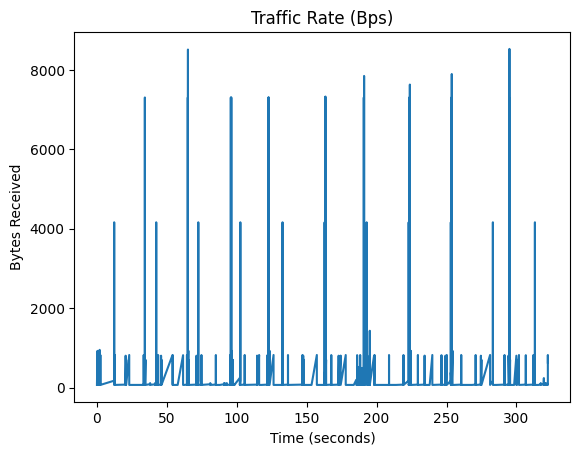

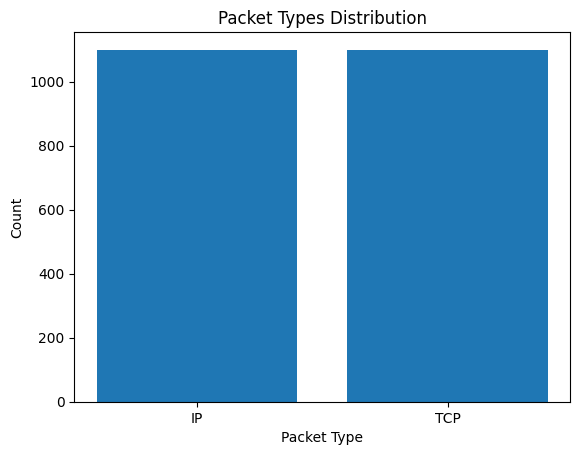

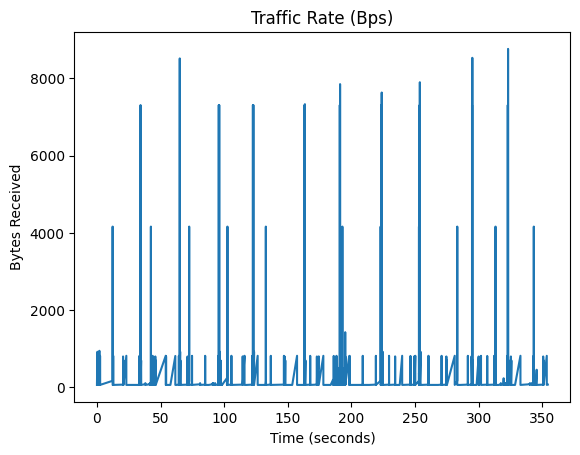

<Sniffed: TCP:0 UDP:0 ICMP:0 Other:0>

In [ ]:
# Specify network interface (e.g., 'eth0' or 'wlan0')
interface = "eth0"
print(f"Sniffing on interface: {interface}")
scapy.sniff(iface=interface, prn=packet_callback, store=False)